In [1]:
#!/usr/bin/env python
# coding: utf-8
import os
from os import system
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from data.trajectory import EnsembleTrajectory, MultiEnsembleTrajectory
from data.dataset import MultiEnsembleDataset
from data.generic import Summary

from tm.core.prior import GlobalEquilibriumHarmonicPrior, UnitNormalPrior
from tm.core.backbone import ConvBackbone
from tm.core.diffusion_model import DiffusionTrainer, SteeredDiffusionSampler
from tm.core.diffusion_process import VPDiffusion
from tm.architectures.unet_2d_mid_attn import Unet2D
#from tm.architectures.UNet2D_pbc import Unet2D
from tm.core.loader import Loader

import os
if not os.path.exists('plots/'):
    os.mkdir('plots')
if not os.path.exists('data/'):
    os.mkdir('data')



In [2]:
# Define the path to the directory you want to change to
# dirc_path = 'thermomaps-root'
# os.chdir(dirc_path)


HighT_chem = np.load('data/high_tmp_accumulated_T7.npy')
LowT_chem = np.load('data/low_tmp_accumulated_T7.npy')
HighT_chem = HighT_chem[0::10]
LowT_chem = LowT_chem[0::10]
# # Change into chem potential
HighT_chem[:, 1, :, :] = 4
LowT_chem[:, 1, :, :] = -4 

np.save('data/HighMuT7.npy', HighT_chem)
np.save('data/LowMuT7.npy', LowT_chem)



chemical_potential = [-4,4]

high_T_data =  np.load('data/'+ 'HighMuT7' +'.npy')
low_T_data =  np.load('data/'+ 'LowMuT7' +'.npy')


def rescale_training_data(low_T_data,high_T_data):
    # rescale the traning data
    # let low T to be the minimum and everything to be -1
    # let high T to be the maximum and everything to be 1

    low_T_data[:,1,:,:] = -4
    high_T_data[:,1,:,:] = 4
    result = np.concatenate((low_T_data,high_T_data))
    return result

def chemicalP_conversion(chemical_potential, mu):
    # convert the selected temperature T into a number between [-1,1]

    lowT, highT = min(chemical_potential), max(chemical_potential)

    ratio = 2/(highT-lowT)
    highT*=ratio

    return (mu*ratio)+1-highT


# Rescale and concatenate the data
training_rescaled = rescale_training_data(low_T_data, high_T_data)

# Add a temperature channel with a value of 1
temperature_channel = np.ones((training_rescaled.shape[0], 1, training_rescaled.shape[2], training_rescaled.shape[3]))
expanded_training_data = np.concatenate((training_rescaled, temperature_channel), axis=1)

print(expanded_training_data.shape)  # This should print (20000, 3, 20, 20)




(10000, 3, 20, 20)


In [10]:
# Initialize pressure values
pressure = np.array([-1.0, 1.0])
pressure_list = np.ones(10000)
temperature_list = 1 * np.ones(10000)

for i in range(2):
    pressure_list[5000 * i:5000 * (i + 1)] = pressure[i]

# Expand the data to include channels for temperature and pressure
expanded_data_final = np.zeros((expanded_training_data.shape[0], 3, expanded_training_data.shape[2], expanded_training_data.shape[3]))

# Copy the original expanded data
expanded_data_final[:, :3, :, :] = expanded_training_data
# Set the 2nd channel to 400 (temperature)
expanded_data_final[:, 1, :, :] = 1
# Set the 3rd channel to the pressure values
expanded_data_final[:, 2, :, :] = pressure_list[:, np.newaxis, np.newaxis]


# Create trajectory dictionary
trajectoryP = {'coordinate': [], 'state_variables': [], 'state_variables_P': []}
trajectoryP['coordinate'] = expanded_data_final[:, :3, :, :]
trajectoryP['state_variables_P'] = pressure_list
trajectoryP['state_variables'] = temperature_list

print(expanded_data_final.shape)  # This should print (20000, 5, 20, 20)

train_loader = Loader(data=trajectoryP['coordinate'], pressures =trajectoryP['state_variables_P'][:,None] , temperatures=trajectoryP['state_variables'][:,None],control_dims=(1,3))#, **TMLoader_kwargs)
prior = GlobalEquilibriumHarmonicPrior(shape=train_loader.data.shape, channels_info={"coordinate": [0], "fluctuation": [1], "mean": [2]})
model = Unet2D(dim=32, dim_mults=(1,2,4), resnet_block_groups=8, channels=3)


backbone = ConvBackbone(model=model,
                        data_shape=train_loader.data_dim,
                        target_shape=32,
                        num_dims=4,
                        lr=1e-3,
                        eval_mode="train",
                        self_condition=True)

diffusion = VPDiffusion(num_diffusion_timesteps=100)


(20000, 3, 20, 20)


In [11]:
# *********************************************************************************
#                               Training
# *********************************************************************************

trainer = DiffusionTrainer(diffusion,
                           backbone,
                           train_loader,
                           prior,
                           model_dir="thermomaps-root/models", # save models every epoch
                           pred_type="noise", # set to "noise" or "x0"
#                            test_loader=test_loader # optional
                           )

trainer.train(1, loss_type="smooth_l1", batch_size=64)



epoch: 0 | train loss: 0.065


In [12]:
# *********************************************************************************
#                               Sampling
# *********************************************************************************

sampler = SteeredDiffusionSampler(diffusion,
                                  backbone,
                                  train_loader,
                                  prior,
                                  pred_type='noise', # must be the same as in DiffusionTrainer
                                  )




In [13]:
def round_lattice(array):
    # sample data extracted from lattice is not a binary number
    # So, we need to convert all the lattice element to 1 or -1
    #
    mean_val = array.mean()
    array = np.array(array)
    #report error if the input is not 2D or not the same length
    if array.ndim != 2:
        raise ValueError("Input must be a 2D array.")
    if len(set(len(row) for row in array)) != 1:
        raise ValueError("All rows of the array must have the same size.")

    i,j = array.shape
    result = np.zeros((i,j))
    for ii in range(i):
        for jj in range(j):
            if array[ii,jj]<0: result[ii,jj] =0
            else: result[ii,jj] = 1
    return result


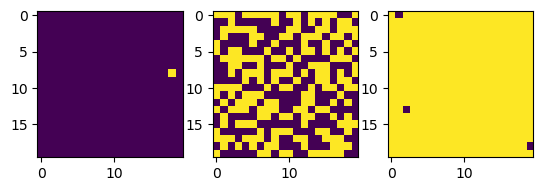

In [14]:
temp = 1
pres_range = [-1,0,1]
num_samp = 1 

samples_low_chem = sampler.sample_loop(num_samples=num_samp, batch_size=16, pressure=pres_range[0]  , temperature=temp)
samples_mid_chem = sampler.sample_loop(num_samples=num_samp, batch_size=16, pressure=pres_range[1] , temperature=temp)
samples_high_chem = sampler.sample_loop(num_samples=num_samp, batch_size=16, pressure=pres_range[2] , temperature=temp)


lattice = samples_low_chem.cpu()[0,0,:,:]
lattice = round_lattice(lattice)

plt.subplot(1,3,1)
plt.imshow(lattice,vmin=0, vmax=1)
# plt.colorbar()

lattice = samples_mid_chem.cpu()[0,0,:,:]
lattice = round_lattice(lattice)
plt.subplot(1,3,2)
plt.imshow(lattice,vmin=0, vmax=1)
# plt.colorbar()

lattice = samples_high_chem.cpu()[0,0,:,:]
lattice = round_lattice(lattice)
plt.subplot(1,3,3)
plt.imshow(lattice,vmin=0, vmax=1)
# plt.colorbar()
plt.savefig('plots/test.pdf')





In [ ]:
# Define temperature and pressure ranges
num_sample = 5

temperature_range = np.linspace(1, 3, num_sample)
pressure_range = np.linspace(-1, 1, num_sample)

# Initialize 2D array to store GC densities
GC_density_heatmap = np.zeros((len(temperature_range), len(pressure_range)))

num_samp = 4
# Generate GC densities for each temperature and pressure combination
for i, temp in enumerate(temperature_range):
    for j, pres in enumerate(pressure_range):
        samples = sampler.sample_loop(num_samples=num_samp , batch_size=16, pressure=pres, temperature=temp)
        lattices = samples.cpu()[:, 0, :, :] 
        
        GC_density_avg = []
        for lattice in lattices:
            lattice = round_lattice(lattice)  # Apply round_lattice to each 2D sample
            density_i = np.sum(lattice) / np.prod(lattice.shape)
            GC_density_avg.append(density_i)
        GC_density_heatmap[i, j] = np.mean(GC_density_avg)

np.save('data/GC_density_heatmap.npy', GC_density_heatmap)



plt.figure(figsize=(8, 6))
plt.imshow(GC_density_heatmap, aspect='auto', origin='lower', extent=[pressure_range.min(), pressure_range.max(), temperature_range.min(), temperature_range.max()], cmap='viridis')
plt.colorbar().set_label(label=r'Density of particle ($\rho$) ', size=15)
plt.xlabel(r'Chemical potential ($\mu$) ')
plt.ylabel('Temperature (T)')
plt.savefig('plots/GC_density_heatmap.pdf', format='pdf')


In [16]:
# # Define temperature and pressure ranges
# temperature_range = np.linspace(1, 3, 25)
# pressure_range = np.linspace(-1, 1, 25)

# # Initialize 2D array to store GC densities
# GC_density_heatmap = np.zeros((len(temperature_range), len(pressure_range)))

# num_samp = 16
# # Generate GC densities for each temperature and pressure combination
# for i, temp in enumerate(temperature_range):
#     for j, pres in enumerate(pressure_range):
#         samples = sampler.sample_loop(num_samples=num_samp , batch_size=16, pressure=pres, temperature=temp)
#         lattices = samples.cpu()[:, 0, :, :] 
        
#         GC_density_avg = []
#         for lattice in lattices:
#             lattice = round_lattice(lattice)  # Apply round_lattice to each 2D sample
#             density_i = np.sum(lattice) / np.prod(lattice.shape)
#             GC_density_avg.append(density_i)
#         GC_density_heatmap[i, j] = np.mean(GC_density_avg)

# np.save('data/GC_density_heatmap.npy', GC_density_heatmap)



# plt.figure(figsize=(8, 6))
# plt.imshow(GC_density_heatmap, aspect='auto', origin='lower', extent=[pressure_range.min(), pressure_range.max(), temperature_range.min(), temperature_range.max()], cmap='viridis')
# plt.colorbar().set_label(label=r'Density of particle ($\rho$) ', size=15)
# plt.xlabel(r'Chemical potential ($\mu$) ')
# plt.ylabel('Temperature (T)')
# plt.savefig('plots/GC_density_heatmap.pdf', format='pdf')
